In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.collections import LineCollection
import seaborn as sns
import re
from math import sqrt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer,SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pip
from IPython.display import IFrame
import warnings
warnings.filterwarnings('ignore')
import missingno as msno

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import importlib
print("Python - 3.10.12")
print("pandas - 1.5.3")
print("numpy - 1.23.5")
print("seaborn - 0.12.2")
print("re - 2.2.1")
print("statsmodels.api - 0.14.0")
print("nltk - 3.8.1")
print("pip - 23.1.2")
print("missingno - 0.5.2")
print("matplotlib - ", importlib.metadata.version('matplotlib'))


Python - 3.10.12
pandas - 1.5.3
numpy - 1.23.5
seaborn - 0.12.2
re - 2.2.1
statsmodels.api - 0.14.0
nltk - 3.8.1
pip - 23.1.2
missingno - 0.5.2
matplotlib -  3.7.1


Importation du Kernle Kaggle

In [5]:
#on enregistre le temps nécessaire à l'execution
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#encodage one-hot pour les colonnes qualitatives
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Fusion des fichiers
    df = pd.read_csv('/content/drive/MyDrive/openclass/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/content/drive/MyDrive/openclass/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: On supprime 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
        # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [6]:


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/content/drive/MyDrive/openclass/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('/content/drive/MyDrive/openclass/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Agrégations , calcul min ,max , ...
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/content/drive/MyDrive/openclass/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Ajout de fonctionnalité: le pourcentage de la demande par rapport par rapport au crédit
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    #On filtre les données pour les applications approuvées et refusées
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [8]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/content/drive/MyDrive/openclass/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [9]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/content/drive/MyDrive/openclass/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [10]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/content/drive/MyDrive/openclass/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [12]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [13]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

Train samples: 73769, test samples: 48744
Bureau df shape: (74434, 115)
Process bureau and bureau_balance - done in 3s
Previous applications df shape: (109899, 247)
Process previous_applications - done in 3s
Pos-cash balance df shape: (108686, 16)
Process POS-CASH balance - done in 1s
Installments payments df shape: (87097, 26)
Process installments payments - done in 2s
Credit card balance df shape: (52736, 131)
Process credit card balance - done in 1s
Full model run - done in 12s


Exploration des données

In [14]:
import os

# Affichage de la liste des différents fichiers
print("Liste des fichiers :")
for file in os.listdir("/content/drive/MyDrive/openclass"):
    if file.endswith(".csv"):
        print("- " + file)

Liste des fichiers :
- sample_submission.csv
- HomeCredit_columns_description.csv
- application_test.csv
- bureau.csv
- installments_payments.csv
- credit_card_balance.csv
- application_train.csv
- POS_CASH_balance.csv
- previous_application.csv
- bureau_balance.csv
- merge.csv
- X_train_balanced.csv
- y_train_balanced.csv


In [15]:
# Jeu d'entraînement
data_train = pd.read_csv('/content/drive/MyDrive/openclass/application_train.csv')
data_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73764,185540,0,Cash loans,F,N,N,0,157500.0,139113.0,15696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
73765,185541,0,Cash loans,F,Y,Y,0,171000.0,1120500.0,41652.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73766,185542,0,Cash loans,F,N,Y,1,90000.0,157500.0,17091.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
73767,185543,0,Revolving loans,M,Y,Y,0,225000.0,450000.0,22500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0


In [16]:
# Jeu test
data_test = pd.read_csv('/content/drive/MyDrive/openclass/application_test.csv')
data_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


La colonne target n'est pas présente dans le jeu test, on va donc chercher à quoi elle correspond.

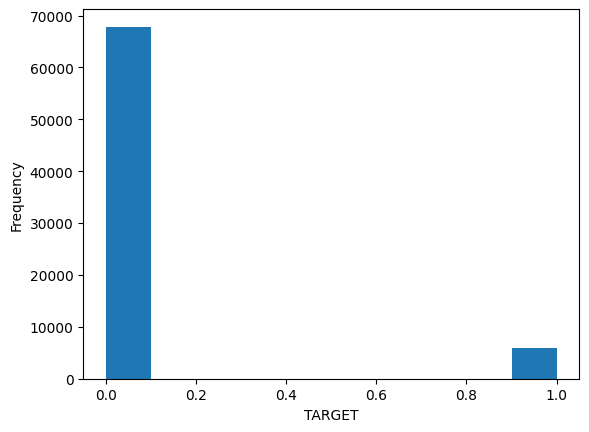

In [17]:
data_train['TARGET'].astype(int).plot.hist();
plt.xlabel('TARGET');

0 correspond aux prets qui ont été remboursés et 1 aux prets qui ont eu des problèmes de remboursements.

On s'intéresse maintenant aux valeurs manquantes.

In [18]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total valeurs manquantes
        mis_val = df.isnull().sum()

        # Pourcentage des valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Table avec les resultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # On renomme les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% Missing'})

        # On trie la table ordre decroissant
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% Missing', ascending=False).round(1)

        #On retourne le dataframe avec info manquante
        return mis_val_table_ren_columns

In [19]:
# Valeurs manquantes data_train
missing_values = missing_values_table(data_train)
missing_values.head(20)

,Missing Values,% Missing
COMMONAREA_MEDI,51509,69.8
COMMONAREA_AVG,51509,69.8
COMMONAREA_MODE,51509,69.8
NONLIVINGAPARTMENTS_MEDI,51173,69.4
NONLIVINGAPARTMENTS_AVG,51173,69.4
NONLIVINGAPARTMENTS_MODE,51173,69.4
LIVINGAPARTMENTS_MEDI,50424,68.4
LIVINGAPARTMENTS_MODE,50424,68.4
LIVINGAPARTMENTS_AVG,50424,68.4
FONDKAPREMONT_MODE,50347,68.2


In [20]:
# Nombre de types de chaque colonne
data_train.dtypes.value_counts()

float64    79
int64      27
object     16
dtype: int64

Analyse univariée

On s'interesse aux variables quantitatives

In [21]:
# Nombre de valeurs uniques pour chaque colonne
data_train.select_dtypes('float').apply(pd.Series.nunique, axis = 0)

AMT_INCOME_TOTAL              1014
AMT_CREDIT                    3819
AMT_ANNUITY                   9895
AMT_GOODS_PRICE                567
REGION_POPULATION_RELATIVE      80
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY        7
AMT_REQ_CREDIT_BUREAU_WEEK       7
AMT_REQ_CREDIT_BUREAU_MON       20
AMT_REQ_CREDIT_BUREAU_QRT        9
AMT_REQ_CREDIT_BUREAU_YEAR      19
Length: 79, dtype: int64

In [22]:
# Nombre de valeurs uniques pour chaque colonne
data_train.select_dtypes('int64').apply(pd.Series.nunique, axis = 0)

SK_ID_CURR                     73769
TARGET                             2
CNT_CHILDREN                      11
DAYS_BIRTH                     16635
DAYS_EMPLOYED                   9086
DAYS_ID_PUBLISH                 5884
FLAG_MOBIL                         2
FLAG_EMP_PHONE                     2
FLAG_WORK_PHONE                    2
FLAG_CONT_MOBILE                   2
FLAG_PHONE                         2
FLAG_EMAIL                         2
REGION_RATING_CLIENT               3
REGION_RATING_CLIENT_W_CITY        3
HOUR_APPR_PROCESS_START           24
REG_REGION_NOT_LIVE_REGION         2
REG_REGION_NOT_WORK_REGION         2
LIVE_REGION_NOT_WORK_REGION        2
REG_CITY_NOT_LIVE_CITY             2
REG_CITY_NOT_WORK_CITY             2
LIVE_CITY_NOT_WORK_CITY            2
FLAG_DOCUMENT_2                    2
FLAG_DOCUMENT_3                    2
FLAG_DOCUMENT_4                    2
FLAG_DOCUMENT_5                    2
FLAG_DOCUMENT_6                    2
FLAG_DOCUMENT_7                    2
d

In [23]:
# Assuming `data_train` is your DataFrame
quantitative_columns = data_train.select_dtypes(["int64", "float"]).columns

# Loop through each quantitative column and create a histogram
for column in quantitative_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data_train[column], bins=20, kde=True)  # You can adjust the number of bins as needed
    plt.title(f'Distribution of Values for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

Puis on s'interesse aux variables qualitatives

In [24]:
# Nombre de valeurs uniques pour chaque colonne
data_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

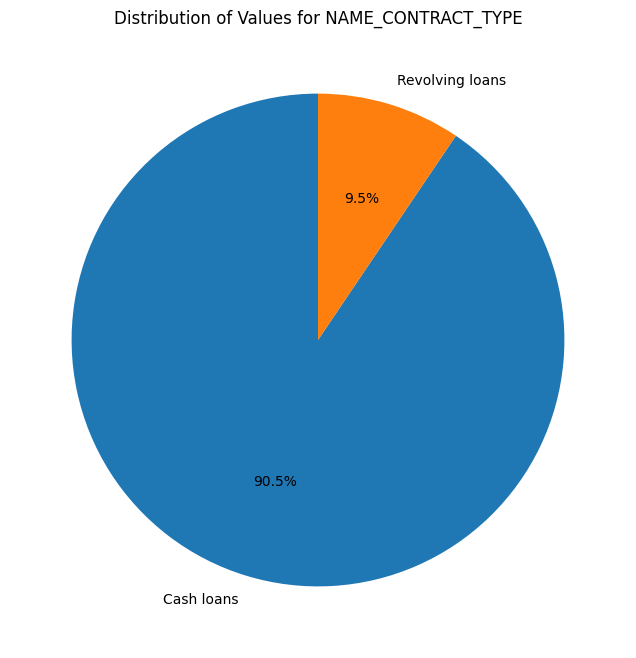

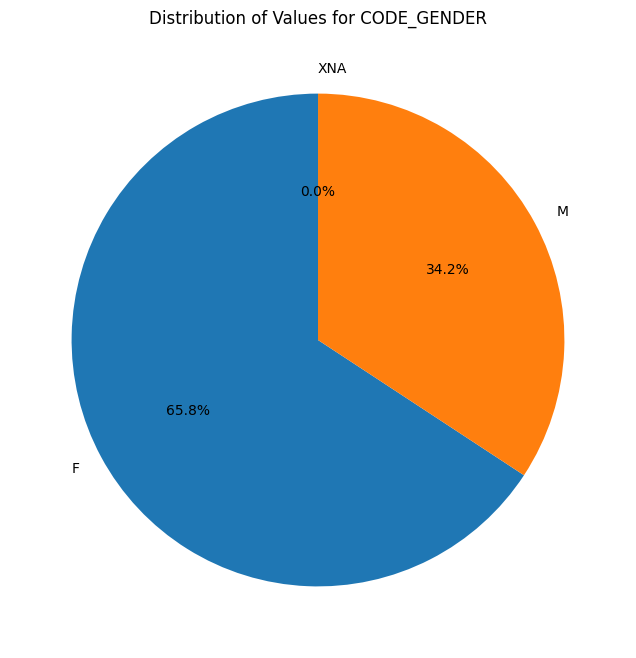

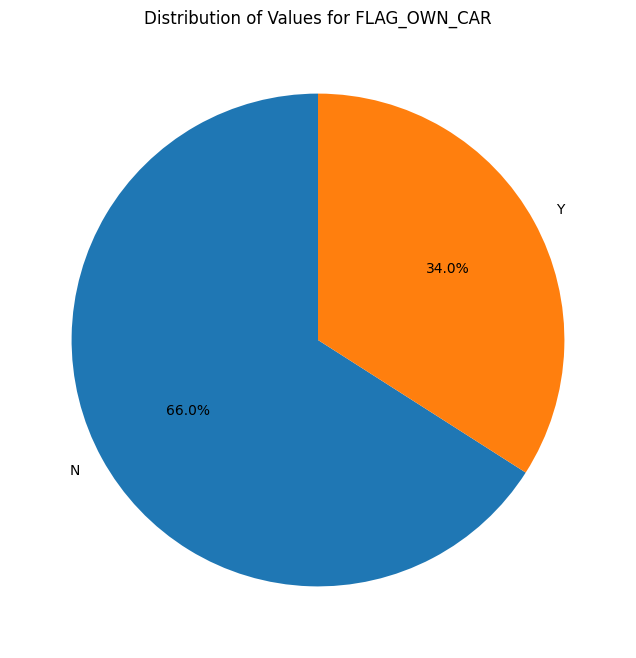

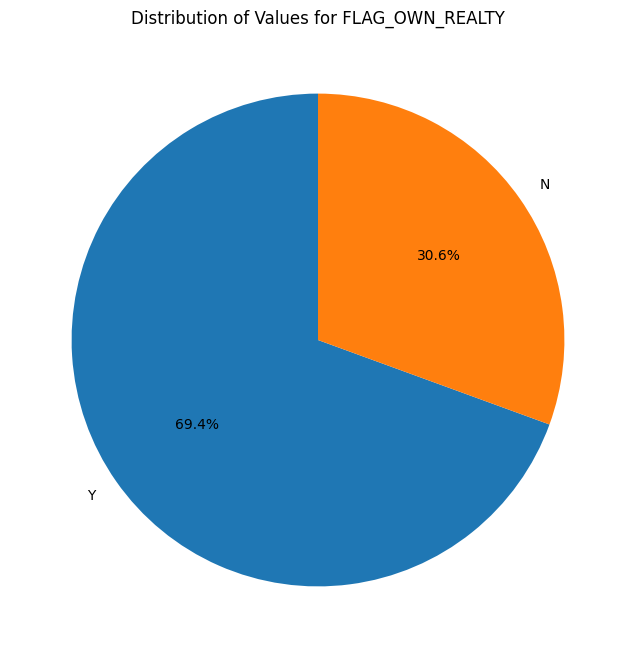

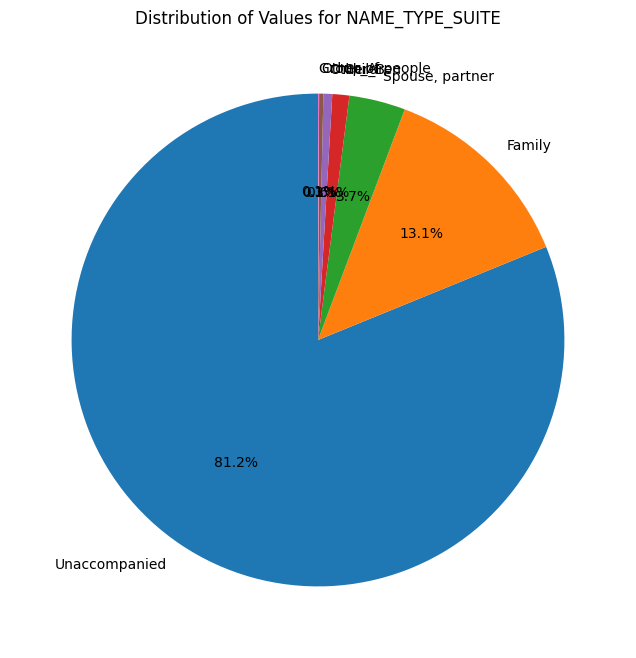

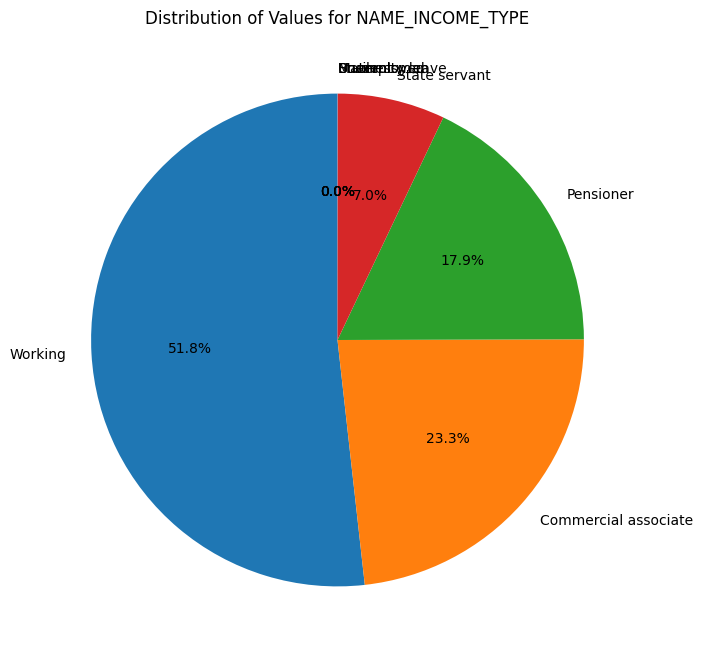

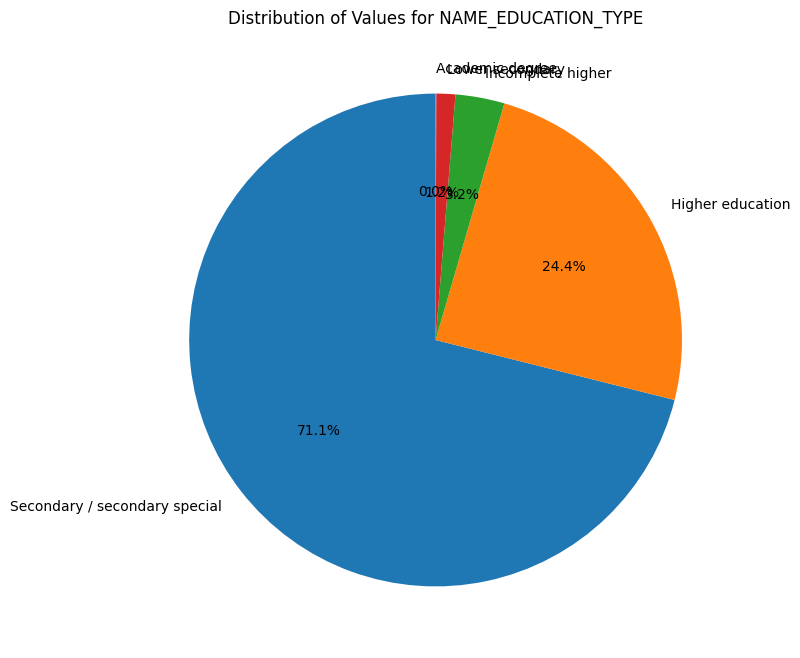

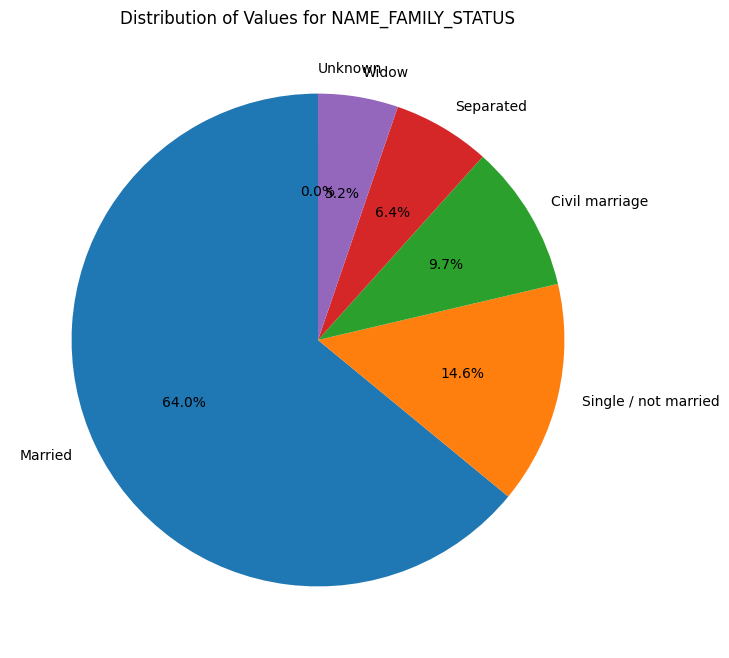

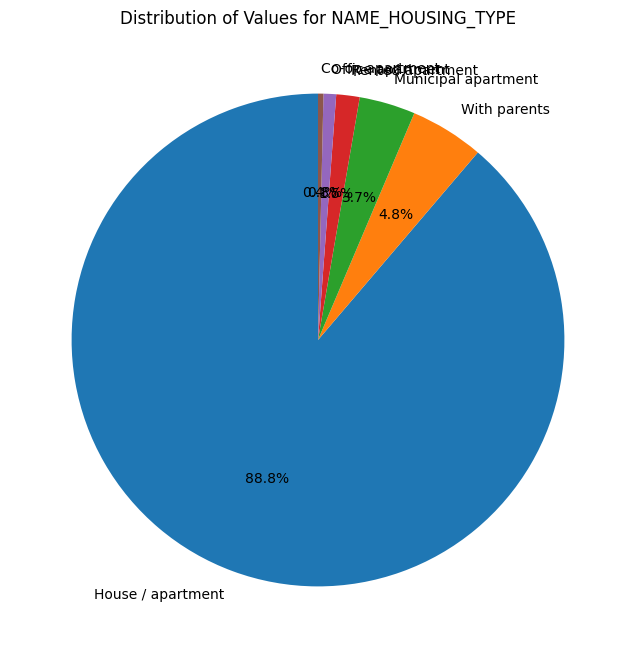

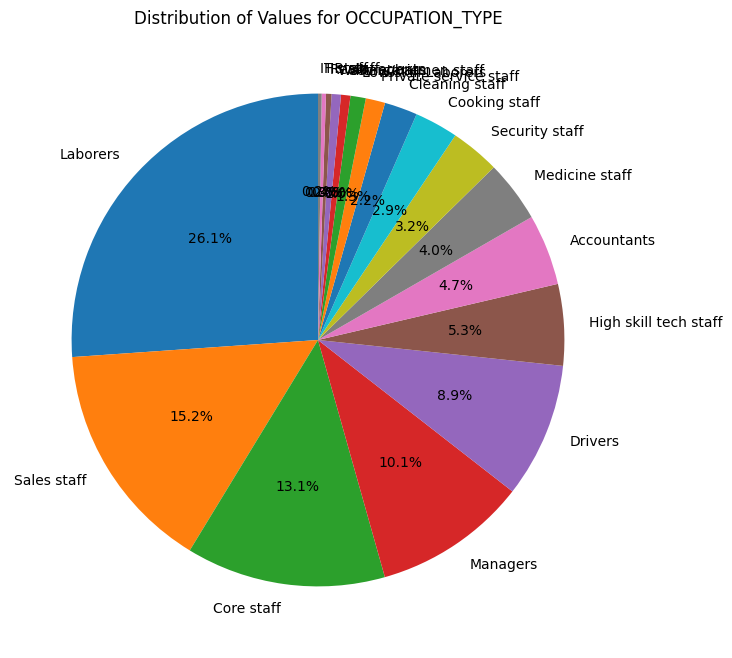

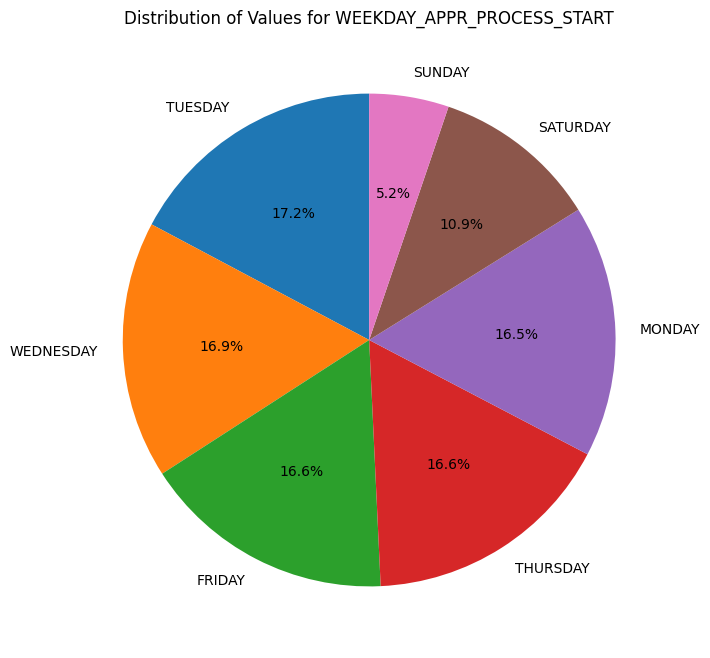

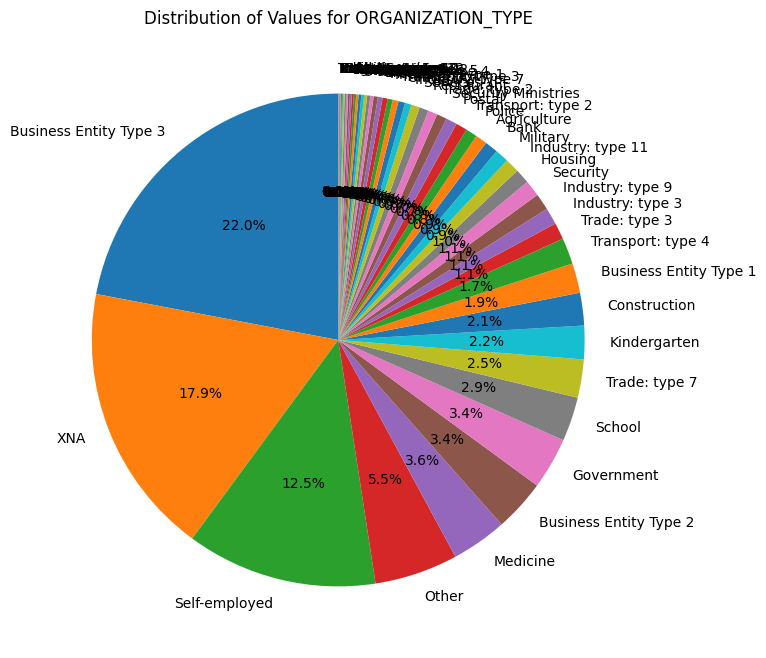

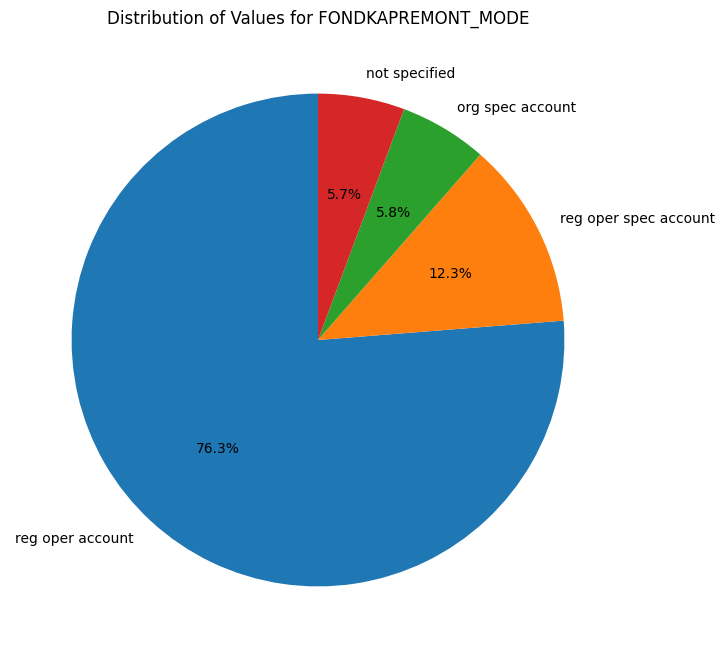

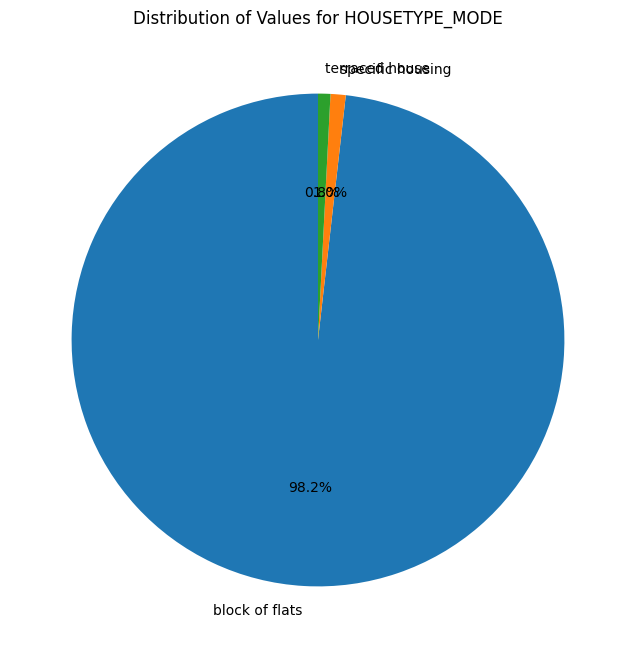

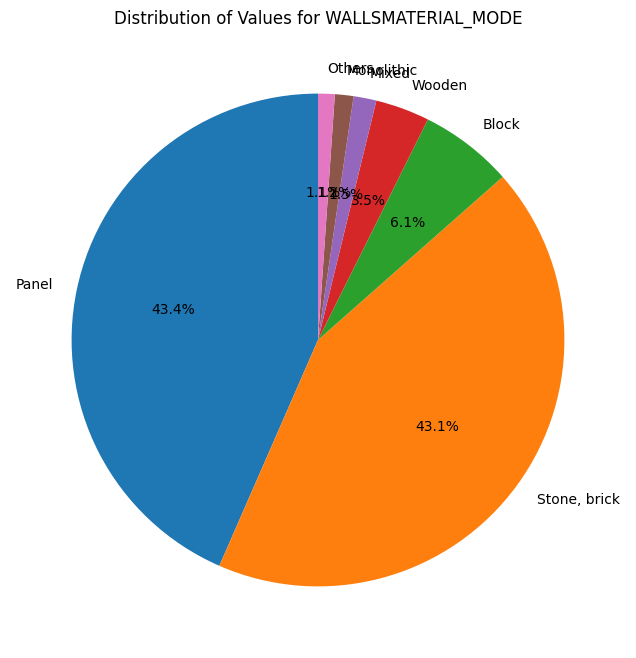

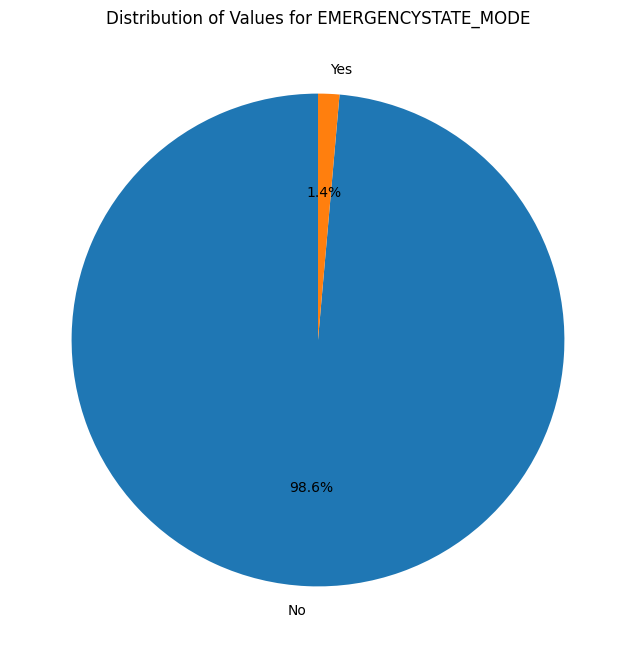

In [25]:
#Selection des variables qualitatives
qualitative_columns = data_train.select_dtypes("object").columns

# Fonction pour trtacer le diagramme circulaire de chacune des variables
for column in qualitative_columns:
    plt.figure(figsize=(8, 8))
    data_train[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribution of Values for {column}')
    plt.ylabel('')  # Remove the y-axis label for better presentation
    plt.show()

Jointure des fichiers, nettoyage et création de nouvelles variables

In [26]:
#On va merger ensemble les fichiers application_train.csv et application_test.csv, pour y effectuer un nettoyage
# Jointure sur la colonne commune
jointure = data_test.append(data_train).reset_index()
# Affichage du résultat
jointure.head()

,index,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
2,2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN
3,3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
4,4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# On verifie si il y'a des doublons basés sur l'id
duplicates = jointure[jointure.duplicated(subset='SK_ID_CURR')]
print(duplicates)

Empty DataFrame
Columns: [index, SK_ID_CURR, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVI

In [28]:
# Calcul du pourcentage de valeurs manquantes pour chaque variable
missing_percentage = (jointure.isnull().mean() * 100).sort_values(ascending=False)

# Création d'un DataFrame pour affichage
missing_data = pd.DataFrame({'Variable': missing_percentage.index, 'Missing Percentage': missing_percentage.values})

# Affichage du DataFrame des valeurs manquantes
print(missing_data)
# Filtrage pour afficher uniquement les variables avec des valeurs manquantes
variables_with_missing = missing_data[missing_data['Missing Percentage'] > 0]

# Affichage des variables avec des valeurs manquantes
print(variables_with_missing)


                     Variable  Missing Percentage
0              COMMONAREA_AVG           69.383657
1             COMMONAREA_MEDI           69.383657
2             COMMONAREA_MODE           69.383657
3     NONLIVINGAPARTMENTS_AVG           68.988597
4    NONLIVINGAPARTMENTS_MEDI           68.988597
..                        ...                 ...
118          NAME_INCOME_TYPE            0.000000
119                AMT_CREDIT            0.000000
120          AMT_INCOME_TOTAL            0.000000
121           FLAG_OWN_REALTY            0.000000
122                     index            0.000000

[123 rows x 2 columns]
                    Variable  Missing Percentage
0             COMMONAREA_AVG           69.383657
1            COMMONAREA_MEDI           69.383657
2            COMMONAREA_MODE           69.383657
3    NONLIVINGAPARTMENTS_AVG           68.988597
4   NONLIVINGAPARTMENTS_MEDI           68.988597
..                       ...                 ...
77          FLAG_DOCUMENT_11     

On supprime les variables avec plus de 50% de valeurs manquantes

In [29]:

# Filtrage des variables avec plus de 50% de valeurs manquantes
variables_to_drop = missing_percentage[missing_percentage > 50].index

# Suppression des variables sélectionnées du DataFrame
jointure = jointure.drop(columns=variables_to_drop)

# Affichage des variables supprimées
print("Variables supprimées:")
print(variables_to_drop)

Variables supprimées:
Index(['COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'FONDKAPREMONT_MODE',
       'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'OWN_CAR_AGE',
       'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'LANDAREA_AVG', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'BASEMENTAREA_MODE',
       'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'NONLIVINGAREA_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MODE',
       'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'EXT_SOURCE_1', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE'],
      dtype='object')


In [30]:
jointure

,index,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
2,2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN
3,3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
4,4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122508,73764,185540,Cash loans,F,N,N,0,157500.0,139113.0,15696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
122509,73765,185541,Cash loans,F,Y,Y,0,171000.0,1120500.0,41652.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122510,73766,185542,Cash loans,F,N,Y,1,90000.0,157500.0,17091.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
122511,73767,185543,Revolving loans,M,Y,Y,0,225000.0,450000.0,22500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0


Nous allons examiner quelque variable individuellement :

SK_ID_CURR : Identifiant unique associé à chaque demande de crédit.

NAME_CONTRACT_TYPE : Type de contrat de prêt. Cela peut indiquer s'il s'agit d'un prêt standard, d'un renouvellement, etc.

CODE_GENDER : Genre du demandeur. Cela indique s'il s'agit d'un homme ou d'une femme.

FLAG_OWN_CAR : Indicateur indiquant si le demandeur possède une voiture (1 si oui, 0 sinon).

FLAG_OWN_REALTY : Indicateur indiquant si le demandeur possède un bien immobilier (1 si oui, 0 sinon).

CNT_CHILDREN : Nombre d'enfants du demandeur.

AMT_INCOME_TOTAL : Revenu total du demandeur.

AMT_CREDIT : Montant du crédit demandé.

AMT_ANNUITY : Montant de l'annuité du crédit.

FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21 : Drapeaux indiquant la présence de certains documents. Ces variables sont binaires (1 si le document est présent, 0 sinon).

AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR : Nombre de demandes d'informations au bureau de crédit au cours de différentes périodes.

TARGET : Variable cible indiquant si le demandeur a eu des problèmes de paiement (1 en cas de défaut de paiement, 0 sinon). C'est souvent la variable que l'on cherche à prédire dans un modèle de scoring de crédit.

In [31]:
# Suppression des variables fortement corrélées
correlation_matrix = jointure.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
jointure = jointure.drop(to_drop, axis=1)

Création de nouvelles variables

In [32]:
#proportion de la vie professionnelle par rapport à la durée totale de la vie
jointure['DAYS_EMPLOYED_PERC'] = jointure['DAYS_EMPLOYED'] / jointure['DAYS_BIRTH']
#capacité d'une personne à rembourser un prêt en fonction de son revenu
jointure['INCOME_CREDIT_PERC'] = jointure['AMT_INCOME_TOTAL'] / jointure['AMT_CREDIT']
#Cette variable représente le revenu par personne, calculé en divisant le revenu total (AMT_INCOME_TOTAL) par le nombre de membres de la famille (CNT_FAM_MEMBERS).
jointure['INCOME_PER_PERSON'] = jointure['AMT_INCOME_TOTAL'] / jointure['CNT_FAM_MEMBERS']
jointure

,index,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON
0,0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.121044,0.237342,67500.0
1,1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,...,0.0,0.0,0.0,0.0,0.0,3.0,NaN,0.247398,0.444409,49500.0
2,2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,...,0.0,0.0,0.0,0.0,1.0,4.0,NaN,0.222477,0.305308,101250.0
3,3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,...,0.0,0.0,0.0,0.0,0.0,3.0,NaN,0.133515,0.200000,78750.0
4,4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.168021,0.287770,60000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122508,73764,185540,Cash loans,F,N,N,0,157500.0,139113.0,15696.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.281317,1.132173,78750.0
122509,73765,185541,Cash loans,F,Y,Y,0,171000.0,1120500.0,41652.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050830,0.152610,171000.0
122510,73766,185542,Cash loans,F,N,Y,1,90000.0,157500.0,17091.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.252283,0.571429,30000.0
122511,73767,185543,Revolving loans,M,Y,Y,0,225000.0,450000.0,22500.0,...,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.042398,0.500000,112500.0


# Imputation des valeurs manquantes pour les variables qualitatives

In [33]:
#Imputation par le mode
# Sélectionnez nos variables qualitatives
categorical_columns = jointure.select_dtypes(include='object').columns
categorical_columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')

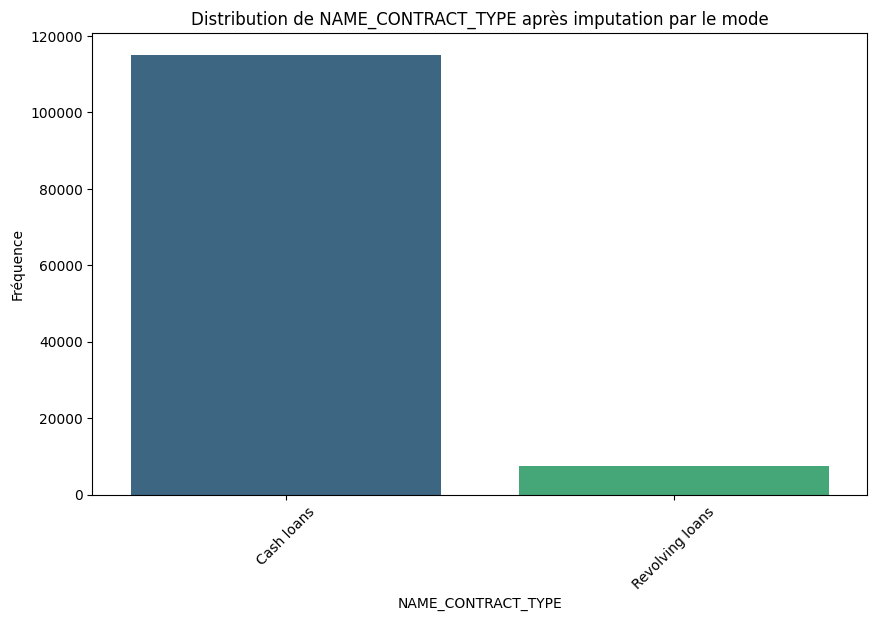

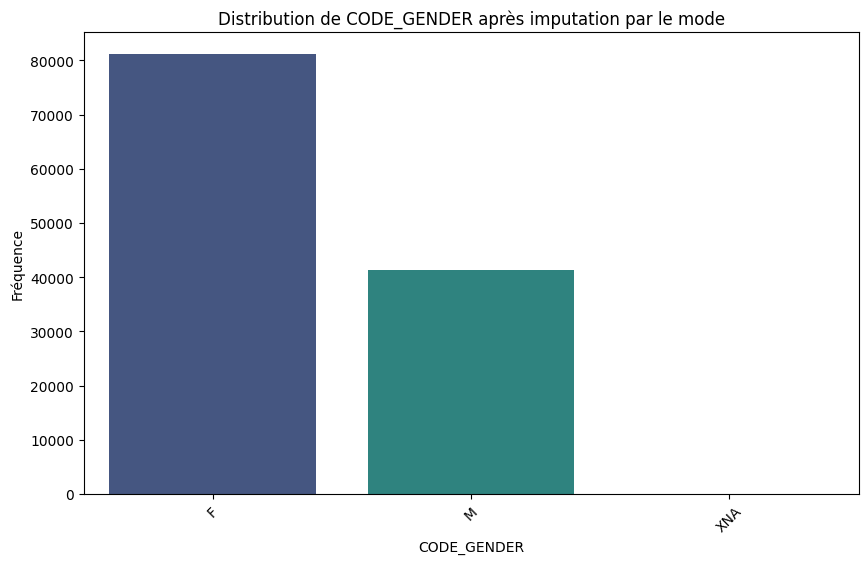

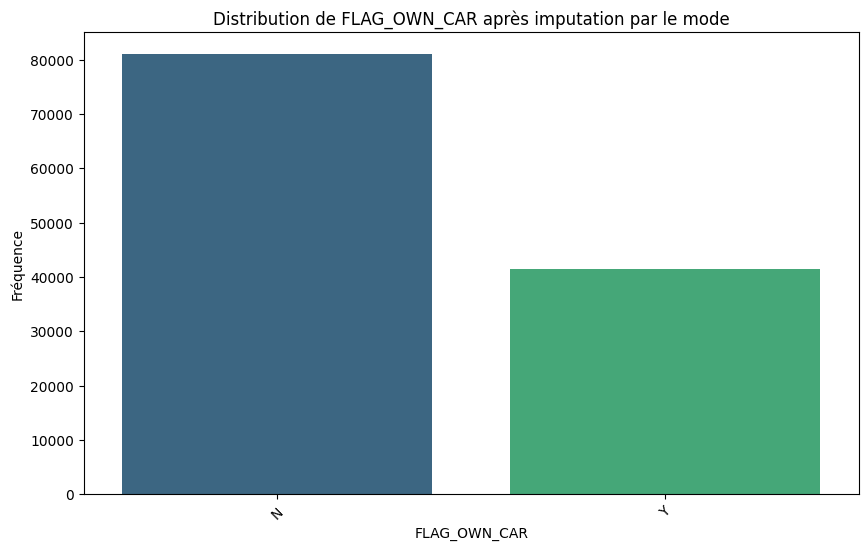

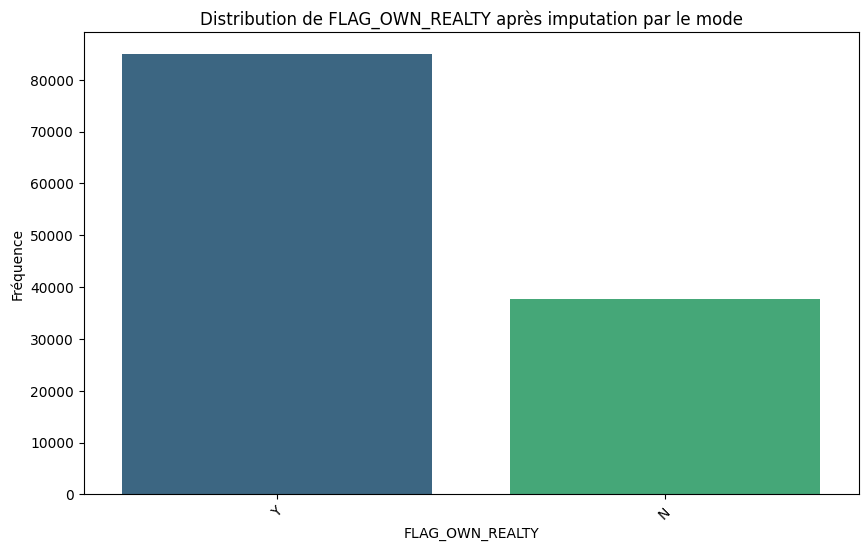

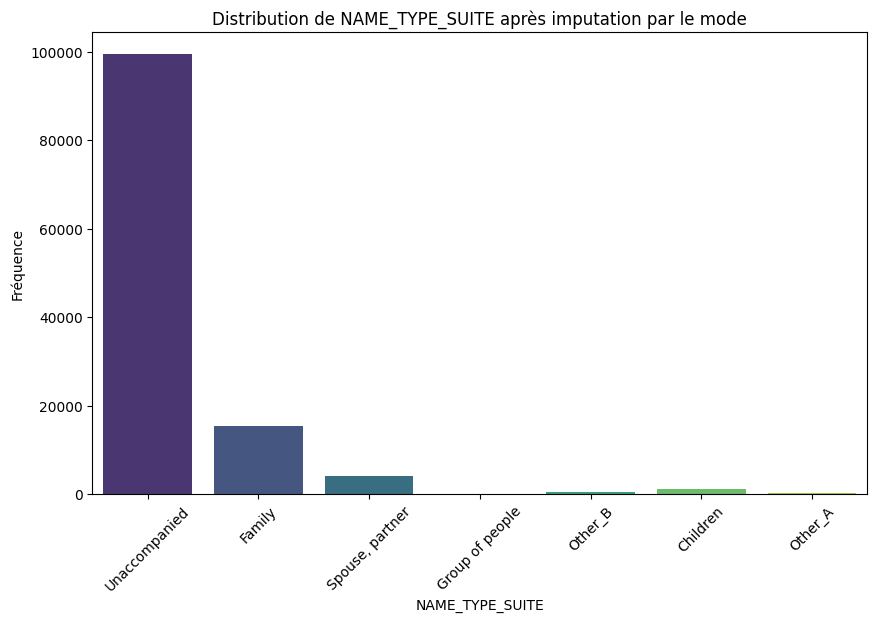

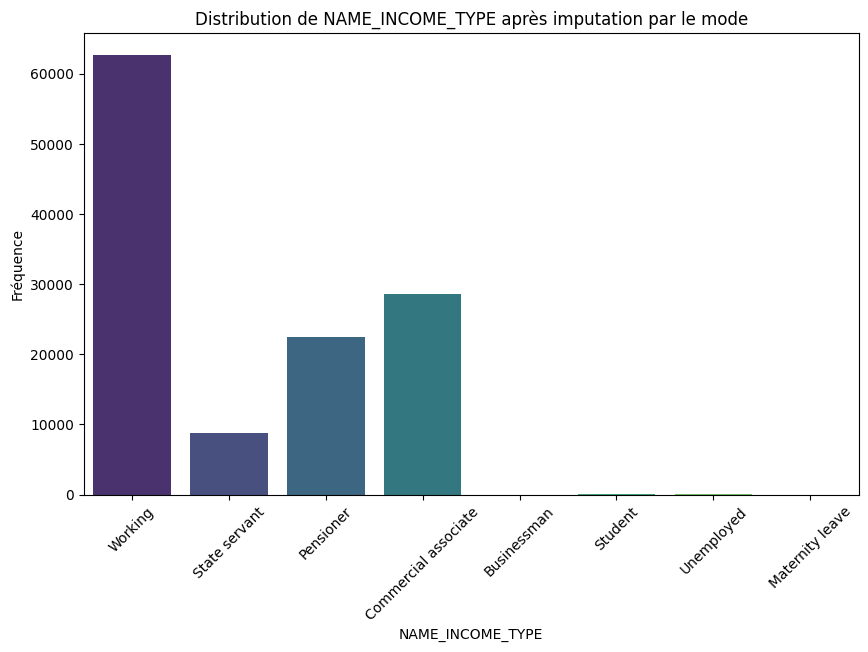

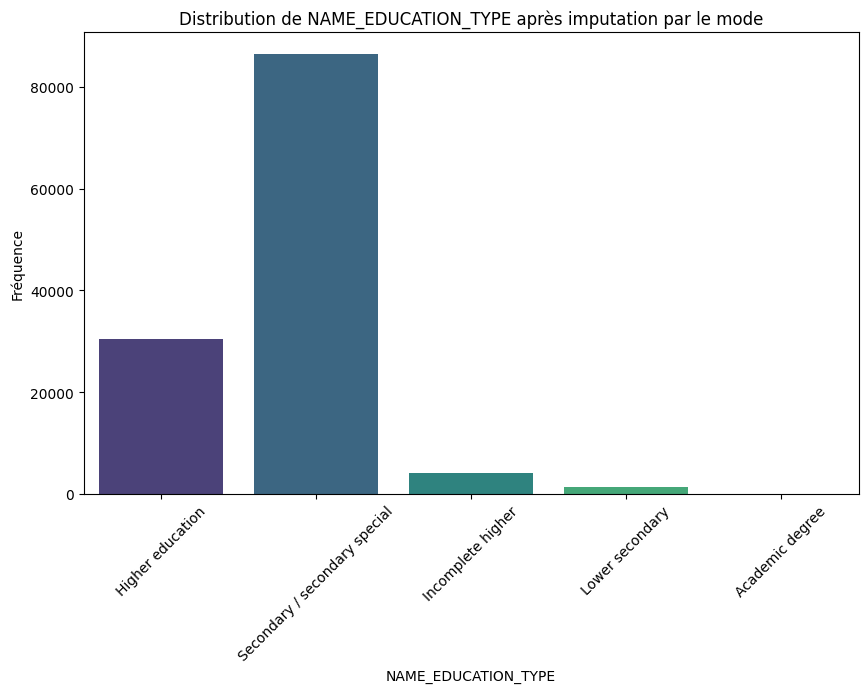

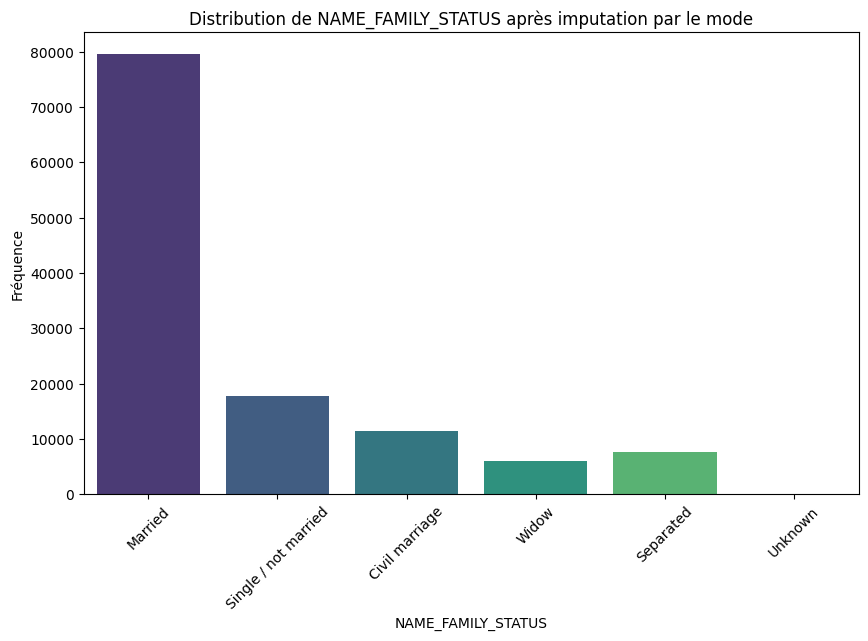

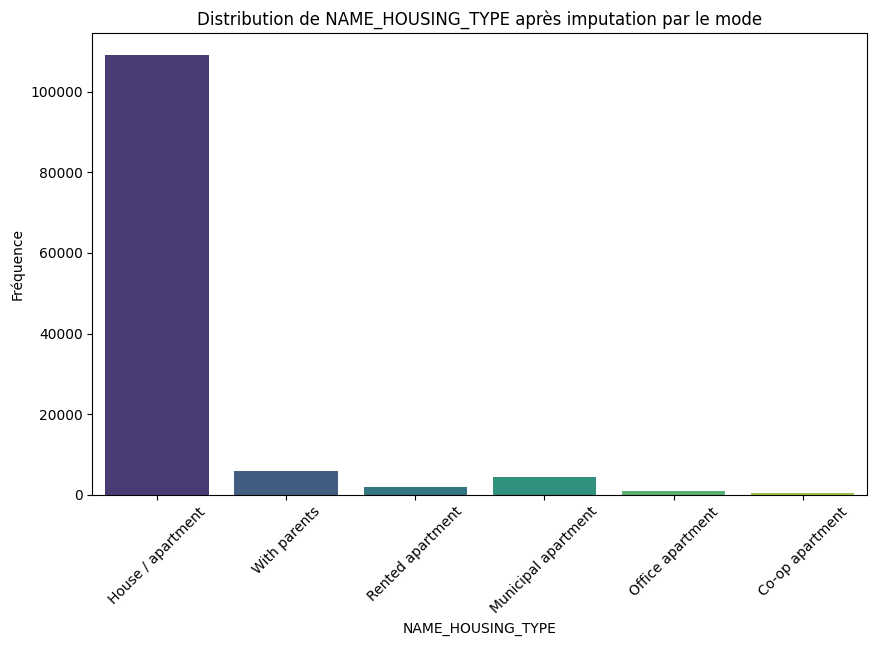

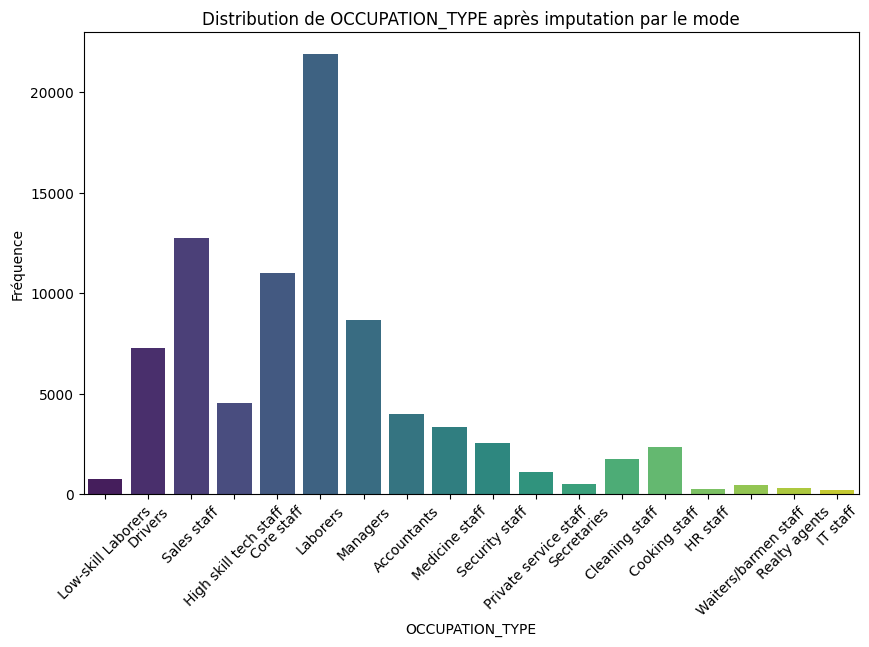

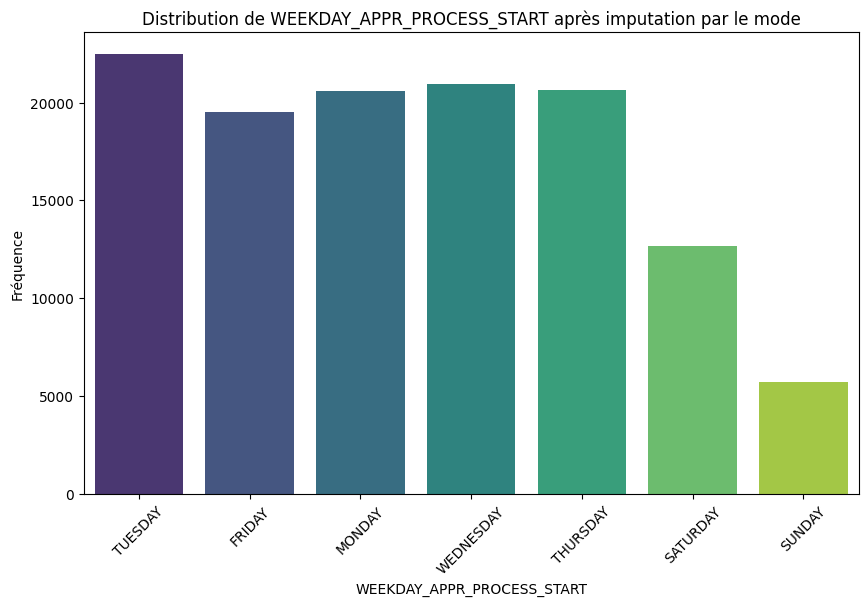

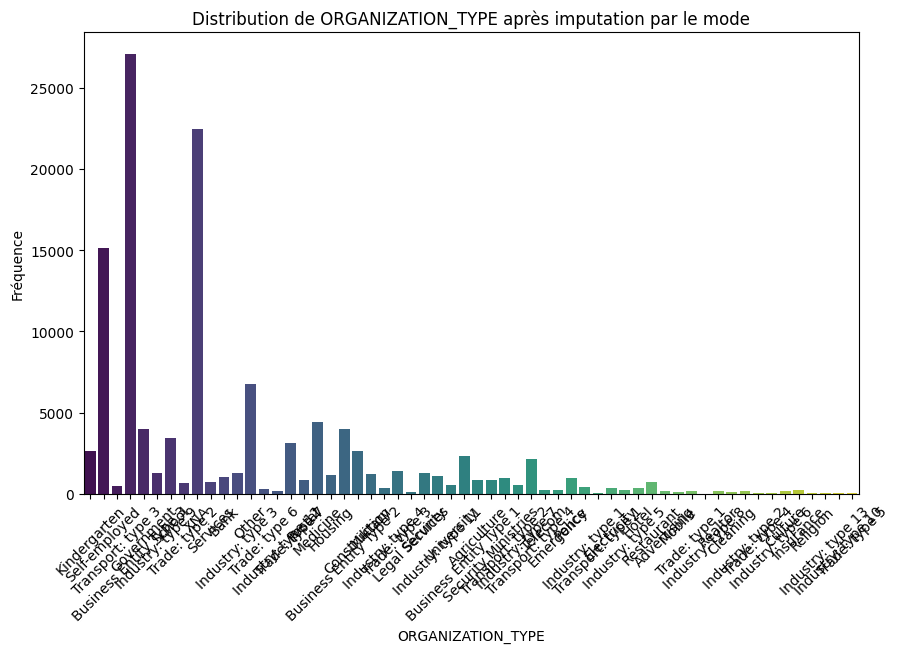

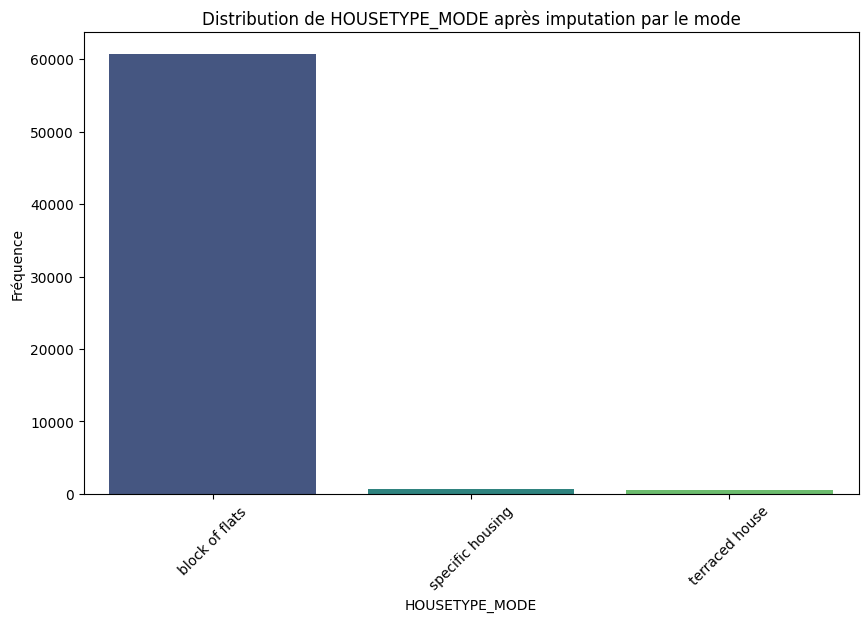

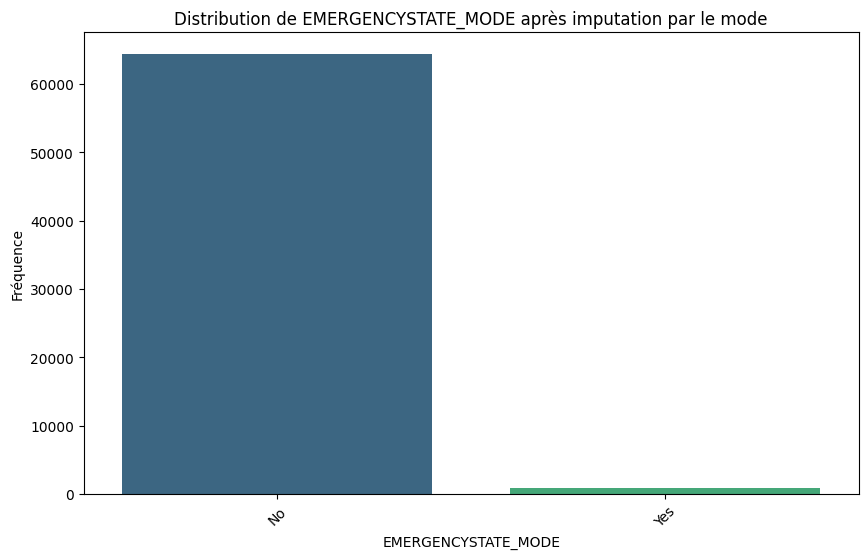

In [34]:
# Réalisez des diagrammes en barres pour chaque variable catégorielle
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=jointure, palette='viridis')
    plt.title(f'Distribution de {column} après imputation par le mode')
    plt.xlabel(column)
    plt.ylabel('Fréquence')
    plt.xticks(rotation=45)
    plt.show()

In [35]:
# Imputation pour les variables qualitatives
qual_imputer = SimpleImputer(strategy='most_frequent')
jointure[categorical_columns] = qual_imputer.fit_transform(jointure[categorical_columns])

# Vérifier le pourcentage de valeurs manquantes après l'imputation
print(jointure.isnull().mean() * 100)

index                          0.000000
SK_ID_CURR                     0.000000
NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_YEAR    12.987193
TARGET                        39.786798
DAYS_EMPLOYED_PERC             0.000000
INCOME_CREDIT_PERC             0.000000
INCOME_PER_PERSON              0.000816
Length: 79, dtype: float64


# Imputation des valeurs manquantes pour les variables quantitatives

In [36]:
# Sélectionnez les variables quantitatives
quantitative_columns = jointure.select_dtypes(include=['int64', 'float64']).columns
variables=quantitative_columns.drop('SK_ID_CURR', errors='ignore')
# Maintenant, quantitative_columns contient les noms des colonnes quantitatives sans SK_ID_CURR
# Maintenant, quantitative_columns contient les noms des colonnes quantitatives sans SK_ID_CURR
print(quantitative_columns)

Index(['index', 'SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DO

In [37]:
#Selection d'un sous-ensemble pour réduire le temps de traitement
# Sélection dun sous-ensemble de 5% des données
data_subset = jointure.sample(frac=0.05, random_state=42)

# Diviser les données en ensemble d'entraînement et de test
train, test = train_test_split(data_subset, test_size=0.2, random_state=42)

In [38]:
# Création d'un DataFrame pour stocker les résultats
results = pd.DataFrame(columns=['Variable', 'Méthode', 'Erreur', 'Pourcentage d\'erreur'])

In [39]:
# Calcul de l'erreur de prédiction pour chaque méthode d'imputation
for target in variables:
    # Sélectionner les autres variables comme variables explicatives
    features = [col for col in variables if col != target]

    # Suppressionm les lignes avec des valeurs manquantes dans la colonne cible
    train_target = train.dropna(subset=[target])
    test_target = test.dropna(subset=[target])

    for method in ['KNN', 'IterativeImputer']:
        if method == 'KNN':
            imputer = KNNImputer(n_neighbors=3)
        elif method == 'IterativeImputer':
            imputer = IterativeImputer(estimator=LinearRegression())

        # Imputer les valeurs manquantes
        train_imputed = imputer.fit_transform(train_target[features])
        test_imputed = imputer.transform(test_target[features])

        # Entraîner le modèle sur les données imputées
        model = LinearRegression()
        model.fit(train_imputed, train_target[target])

        # Prédire la variable cible sur l'ensemble de test
        predictions = model.predict(test_imputed)

        # Calcul de  l'erreur de prédiction
        error = mean_squared_error(test_target[target], predictions)

        # Calcul de l'erreur en pourcentage
        range_target = test_target[target].max() - test_target[target].min()
        percent_error = error / range_target * 100

        # Ajout des résultats au DataFrame
        results = results.append({'Variable': target, 'Méthode': method, 'Erreur': error, 'Pourcentage d\'erreur': percent_error}, ignore_index=True)

# Afficher les résultats
results

In [40]:
# Supposons que 'results' est le DataFrame contenant les résultats
# Adaptation en fonction de votre structure de données

# Trouver la méthode avec l'erreur minimale pour chaque variable
best_methods = results.loc[results.groupby('Variable')['Erreur'].idxmin()][['Variable', 'Méthode']]

# Afficher les résultats
print(best_methods)


                        Variable           Méthode
8                    AMT_ANNUITY               KNN
6                     AMT_CREDIT               KNN
5               AMT_INCOME_TOTAL  IterativeImputer
111    AMT_REQ_CREDIT_BUREAU_DAY  IterativeImputer
109   AMT_REQ_CREDIT_BUREAU_HOUR  IterativeImputer
..                           ...               ...
36    REG_REGION_NOT_LIVE_REGION               KNN
38    REG_REGION_NOT_WORK_REGION               KNN
120                       TARGET               KNN
52   YEARS_BEGINEXPLUATATION_AVG               KNN
0                          index               KNN

[64 rows x 2 columns]


In [41]:
# Filtrer les résultats pour ne garder que les lignes avec la méthode 'KNN'
knn_results = results[results['Méthode'] == 'KNN']
# Création d'un sous-ensemble de DataFrame avec 5% des données
subset_products_data =jointure.sample(frac=0.05, random_state=1)
# Liste des variables pour l Iterative Imputer
IterativeImputer_variables = results[results['Méthode'] == 'IterativeImputer']
# Instanciation de l'IterativeImputer
imputer = IterativeImputer(random_state=0)
# Liste des colonnes à imputer avec IterativeImputer
columns_to_impute = IterativeImputer_variables

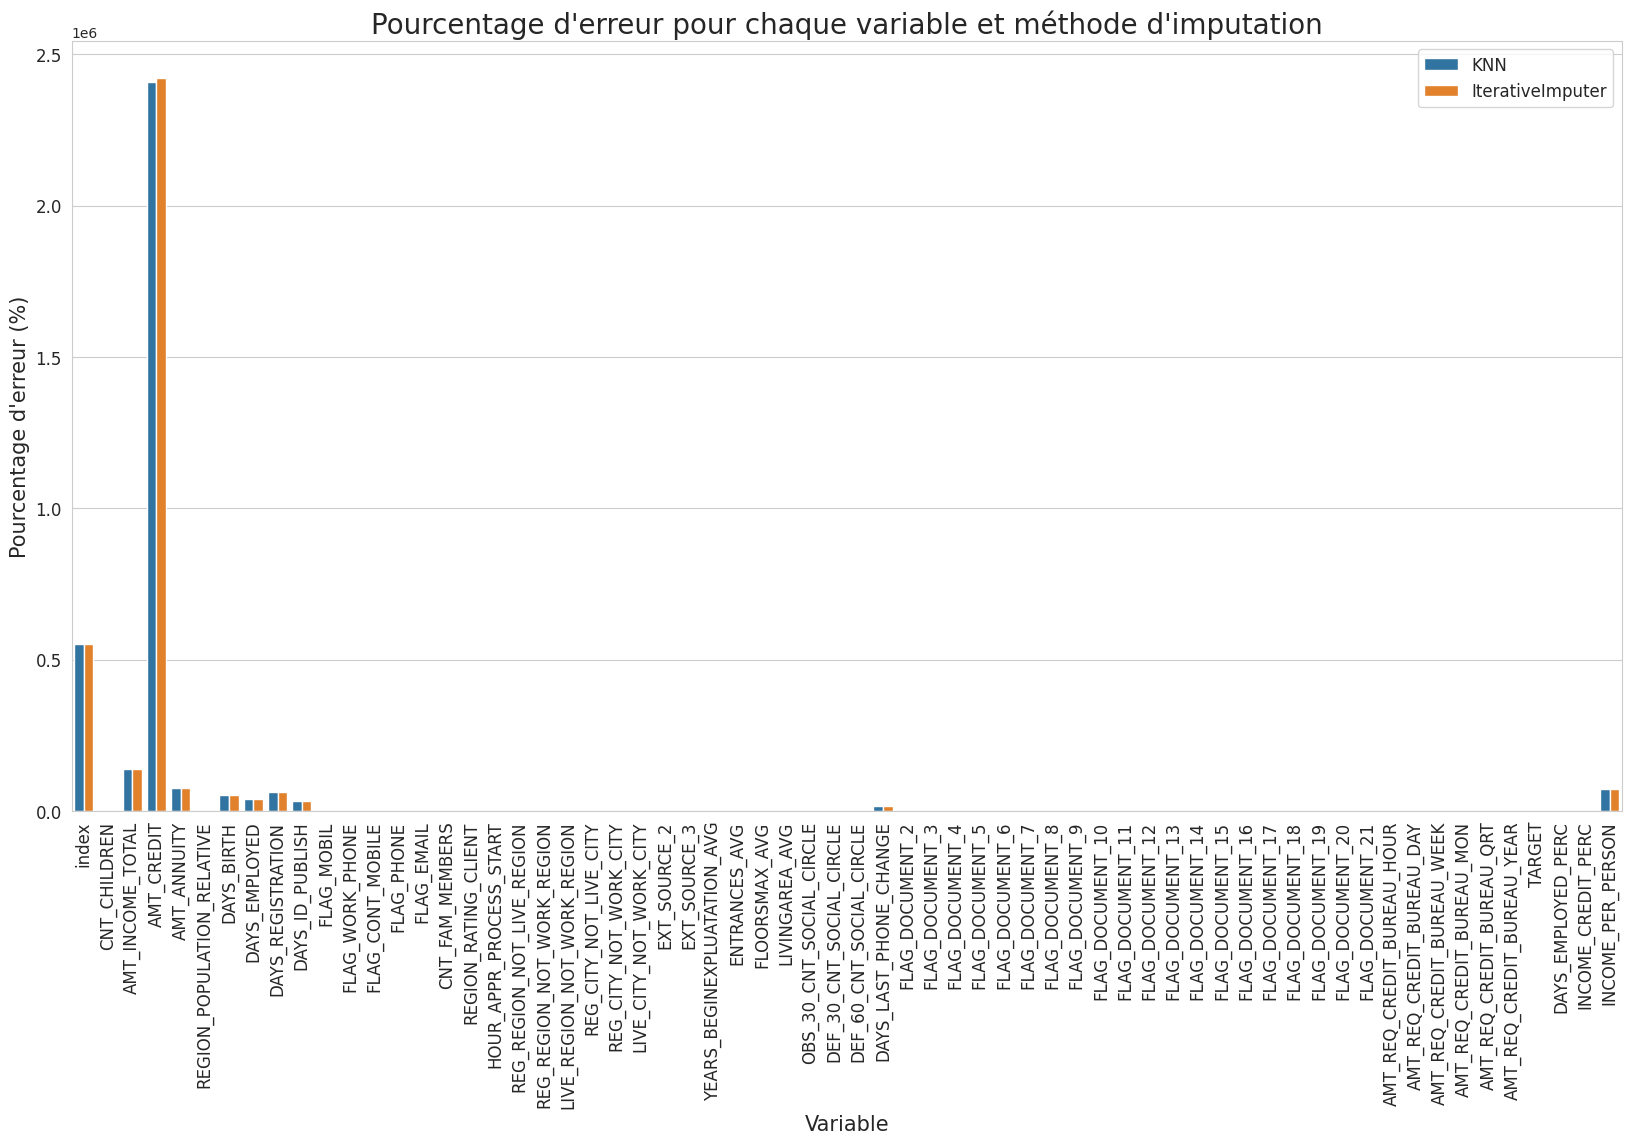

In [42]:

# Afficher les résultats
plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")
sns.barplot(x='Variable', y='Pourcentage d\'erreur', hue='Méthode', data=results)
plt.title('Pourcentage d\'erreur pour chaque variable et méthode d\'imputation', fontsize=20)
plt.xlabel('Variable', fontsize=15)
plt.ylabel('Pourcentage d\'erreur (%)', fontsize=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()


On impute pour chaque variable avec la méthode qui lui est la plus efficace

In [43]:
# Instanciation de l'IterativeImputer
imputer = IterativeImputer(random_state=0)

# Liste des colonnes à imputer avec IterativeImputer
columns_to_impute = IterativeImputer_variables


In [44]:
from sklearn.impute import IterativeImputer
import pandas as pd

# Create an IterativeImputer instance
imputer = IterativeImputer()

# Imputation of missing values for each selected column
for column in columns_to_impute:
    if column not in subset_products_data.columns:
        print(f"Warning: Column '{column}' not found in the DataFrame.")
        continue

    # Extract the column as a 2D array (required by IterativeImputer)
    column_data = subset_products_data[[column]].values

    # Impute missing values using fit_transform
    imputed_column = imputer.fit_transform(column_data)

    # Assign the imputed values back to the DataFrame
    subset_products_data[column] = imputed_column

# Verification of the remaining percentage of missing values
print(subset_products_data.isnull().mean())


index                         0.000000
SK_ID_CURR                    0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_YEAR    0.128469
TARGET                        0.393895
DAYS_EMPLOYED_PERC            0.000000
INCOME_CREDIT_PERC            0.000000
INCOME_PER_PERSON             0.000000
Length: 79, dtype: float64


In [45]:
from sklearn.impute import KNNImputer

columns_to_impute = knn_results
# Create a KNNImputer instance
imputer = KNNImputer()

# Imputation of missing values for each selected column
for column in columns_to_impute:
    if column not in subset_products_data.columns:
        print(f"Warning: Column '{column}' not found in the DataFrame.")
        continue

    # Extract the column as a 2D array (required by KNNImputer)
    column_data = subset_products_data[[column]].values

    # Impute missing values using fit_transform
    imputed_column = imputer.fit_transform(column_data)

    # Assign the imputed values back to the DataFrame
    subset_products_data[column] = imputed_column

# Verification of the remaining percentage of missing values
print(subset_products_data.isnull().mean())


index                         0.000000
SK_ID_CURR                    0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_YEAR    0.128469
TARGET                        0.393895
DAYS_EMPLOYED_PERC            0.000000
INCOME_CREDIT_PERC            0.000000
INCOME_PER_PERSON             0.000000
Length: 79, dtype: float64


Encodage des variables catégorielles
Ici on va encoder les variables qualitatives afin de transformer les données en valeurs numériques, car les modèles que l'on va entraîner ne peuvent pas travailler sur des données qualitatives.

Pour les variables n'ayant que 2 valeurs possibles, on va simplement changer les valeurs en valeurs numériques.

Par contre pour les variables qui ont plus de 2 valeurs possibles, on va utiliser le one hot encoding, parce qu'on ne veut pas créer d'ordre entre les valeurs comme 0 < 1 < 2 ....

Le one hot encoding va diviser la colonne en plusieurs autres colonnes (une colonne pour chaque valeur possible), et indiquer 1 pou 0 dans les valeurs, en fonction de quelle colonne a quelle valeur.

In [46]:
data_object_infos =subset_products_data.select_dtypes("object").describe().T
data_object_infos["unique"] = subset_products_data.select_dtypes("object").apply( pd.Series.unique, axis=0)
data_object_infos["nunique"] = subset_products_data.select_dtypes("object").apply( pd.Series.nunique, axis=0)
data_object_infos

,count,unique,top,freq,nunique
NAME_CONTRACT_TYPE,6126,"[Cash loans, Revolving loans]",Cash loans,5742,2
CODE_GENDER,6126,"[F, M, XNA]",F,4005,3
FLAG_OWN_CAR,6126,"[Y, N]",N,4037,2
FLAG_OWN_REALTY,6126,"[Y, N]",Y,4291,2
NAME_TYPE_SUITE,6126,"[Unaccompanied, Family, Spouse, partner, Child...",Unaccompanied,4992,7
NAME_INCOME_TYPE,6126,"[Commercial associate, Working, State servant,...",Working,3172,6
NAME_EDUCATION_TYPE,6126,"[Higher education, Secondary / secondary speci...",Secondary / secondary special,4332,5
NAME_FAMILY_STATUS,6126,"[Single / not married, Separated, Married, Civ...",Married,3935,5
NAME_HOUSING_TYPE,6126,"[With parents, House / apartment, Municipal ap...",House / apartment,5483,6
OCCUPATION_TYPE,6126,"[Sales staff, Laborers, High skill tech staff,...",Laborers,2952,18


In [47]:
data=subset_products_data

In [48]:
# Importation du LabelEncoder depuis scikit-learn
from sklearn.preprocessing import LabelEncoder

# Initialisation du LabelEncoder et des compteurs
le = LabelEncoder()         # Création d'un objet LabelEncoder
le_count = 0                # Compteur pour suivre le nombre de colonnes encodées
col_encoded = []            # Liste pour stocker les noms des colonnes encodées

# Boucle à travers les colonnes du dataframe
for col in data:

    # Vérification du type de données de la colonne
    if data[col].dtype == 'object':

        # Vérification du nombre unique de catégories dans la colonne
        if len(list(data[col].unique())) <= 2:

            # Encodage de la colonne avec le LabelEncoder
            le.fit(data[col])             # Ajustement du LabelEncoder sur les valeurs


In [49]:
#On récupère un train_data qui contient la colonne TARGET avec des valeurs valorisées à 0 ou 1, et un test_data qui n'a que des NaN dans la colonne TARGET

train_data = data[data['TARGET'].notnull()]
test_data = data[data['TARGET'].isnull()]
train_data.head()

,index,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON
53765,5021,105873,Cash loans,F,Y,Y,0,157500.0,354276.0,20466.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.039499,0.444569,157500.0
98809,50065,157956,Cash loans,F,Y,Y,1,112500.0,312768.0,16506.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173586,0.359692,37500.0
107235,58491,167797,Cash loans,M,N,Y,1,360000.0,540000.0,33165.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.144323,0.666667,120000.0
122321,73577,185322,Cash loans,M,N,N,0,202500.0,1125000.0,36292.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.116302,0.180000,101250.0
86704,37960,143966,Cash loans,F,N,Y,1,103500.0,523597.5,20893.5,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.564594,0.197671,34500.0


In [50]:
#On récupère un train_data qui contient la colonne TARGET avec des valeurs valorisées à 0 ou 1, et un test_data qui n'a que des NaN dans la colonne TARGET

train_data = data[data['TARGET'].notnull()]
test_data = data[data['TARGET'].isnull()]


In [51]:
train_data.head()

,index,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON
53765,5021,105873,Cash loans,F,Y,Y,0,157500.0,354276.0,20466.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.039499,0.444569,157500.0
98809,50065,157956,Cash loans,F,Y,Y,1,112500.0,312768.0,16506.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173586,0.359692,37500.0
107235,58491,167797,Cash loans,M,N,Y,1,360000.0,540000.0,33165.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.144323,0.666667,120000.0
122321,73577,185322,Cash loans,M,N,N,0,202500.0,1125000.0,36292.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.116302,0.180000,101250.0
86704,37960,143966,Cash loans,F,N,Y,1,103500.0,523597.5,20893.5,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.564594,0.197671,34500.0


In [52]:
#Préparation des données
#On va préparer les données avant de les utiliser pour l'entraînement des modèles.

#Il faut d'abord séparer le data en un jeu de données pour l'entraînement et un autre pour les tests qui servira à mesurer la précision de notre modèle. (80% en données d'entraînement et 20% en données de test)
from sklearn import model_selection

X =train_data.drop(['TARGET'], axis=1)
y = train_data['TARGET']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)


Analyse en composantes principales (ACP)

In [53]:
#Nous enregistrons la variable qualitative dans une variable vf :
vqual =  train_data.select_dtypes(include=['object'])
vqual
#et nos variables quantitaves dans une variable billets_num :
columns = train_data.select_dtypes(include=['float64', 'int64'])
columns

,index,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON
53765,5021,105873,0,157500.0,354276.0,20466.0,0.001276,-9747,-385,-4203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.039499,0.444569,157500.00
98809,50065,157956,1,112500.0,312768.0,16506.0,0.007020,-14765,-2563,-7812.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173586,0.359692,37500.00
107235,58491,167797,1,360000.0,540000.0,33165.0,0.026392,-14322,-2067,-8209.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.144323,0.666667,120000.00
122321,73577,185322,0,202500.0,1125000.0,36292.5,0.035792,-20997,-2442,-1984.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.116302,0.180000,101250.00
86704,37960,143966,1,103500.0,523597.5,20893.5,0.025164,-15698,-8863,-8335.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.564594,0.197671,34500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94051,45307,152481,0,90000.0,284400.0,10849.5,0.030755,-18675,-834,-12844.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.044659,0.316456,45000.00
114215,65471,175927,0,337500.0,808650.0,26086.5,0.030755,-22178,-211,-3037.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.009514,0.417362,168750.00
72366,23622,127489,0,157500.0,560664.0,21852.0,0.007305,-17167,-2010,-621.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.117085,0.280917,157500.00
49709,965,101115,1,202500.0,266652.0,14593.5,0.008866,-10218,-313,-1606.0,...,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.030632,0.759417,67500.00


In [54]:
from sklearn.preprocessing import StandardScaler
#On centre-réduit
X = columns
# On instancie
scaler = StandardScaler()
# On fit
scaler.fit(X)

# On transforme
X_scaled = scaler.transform(X)

In [55]:
from sklearn.impute import SimpleImputer

# Créez une instance de l'imputeur
imputer = SimpleImputer(strategy='mean')

# Appliquez l'imputation sur vos données
X_imputed = imputer.fit_transform(X_scaled)
from sklearn.decomposition import PCA

# Supposons que vous avez déjà défini X_imputed (vos données après imputation)




In [56]:
# On importe la fonction PCA de scikit_learn
from sklearn.decomposition import PCA

# On créé le modèle PCA
model_pca = PCA()

# On fit le modèle avec les données
X_reduced = model_pca.fit_transform(X_imputed)

In [57]:
# La variance captée par chaque nouvelle composante.
model_pca.explained_variance_ratio_
#Ici la 1ère composante capte % de la variance de nos données initiales, la 2ème % etc.

array([7.11986376e-02, 5.47673492e-02, 4.30591106e-02, 3.62223193e-02,
       3.45650078e-02, 3.36696649e-02, 3.22477318e-02, 2.94755993e-02,
       2.65495910e-02, 2.51757969e-02, 2.32519264e-02, 2.20812574e-02,
       2.14171258e-02, 2.06965876e-02, 2.02801766e-02, 1.93567429e-02,
       1.90691517e-02, 1.84145556e-02, 1.82095867e-02, 1.81602000e-02,
       1.79236974e-02, 1.77085347e-02, 1.76345904e-02, 1.73867711e-02,
       1.72657272e-02, 1.66175069e-02, 1.64629718e-02, 1.64122004e-02,
       1.60147212e-02, 1.54524110e-02, 1.50348851e-02, 1.48034010e-02,
       1.46907750e-02, 1.43520610e-02, 1.42089995e-02, 1.38340732e-02,
       1.37904589e-02, 1.29118634e-02, 1.25061530e-02, 1.20240515e-02,
       1.14656646e-02, 1.13449467e-02, 1.06011731e-02, 1.01587197e-02,
       9.94696712e-03, 8.64764498e-03, 7.85234666e-03, 7.23124858e-03,
       6.92637487e-03, 4.97135145e-03, 3.68648188e-03, 3.13534975e-03,
       2.60569551e-03, 2.47052737e-03, 1.36969766e-03, 1.08597836e-03,
      

In [58]:
# Enregister cela dans une variable
scree = (model_pca.explained_variance_ratio_*100).round(2)
scree

array([7.12, 5.48, 4.31, 3.62, 3.46, 3.37, 3.22, 2.95, 2.65, 2.52, 2.33,
       2.21, 2.14, 2.07, 2.03, 1.94, 1.91, 1.84, 1.82, 1.82, 1.79, 1.77,
       1.76, 1.74, 1.73, 1.66, 1.65, 1.64, 1.6 , 1.55, 1.5 , 1.48, 1.47,
       1.44, 1.42, 1.38, 1.38, 1.29, 1.25, 1.2 , 1.15, 1.13, 1.06, 1.02,
       0.99, 0.86, 0.79, 0.72, 0.69, 0.5 , 0.37, 0.31, 0.26, 0.25, 0.14,
       0.11, 0.08, 0.07, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [59]:
#Pour faire une somme cumulée numpy dispose de la fonction cumsum :
scree_cum = scree.cumsum().round()
scree_cum

array([  7.,  13.,  17.,  21.,  24.,  27.,  31.,  34.,  36.,  39.,  41.,
        43.,  45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  62.,
        64.,  66.,  68.,  69.,  71.,  73.,  74.,  76.,  77.,  79.,  80.,
        82.,  83.,  84.,  86.,  87.,  88.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  97.,  98.,  98.,  99.,  99.,  99., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

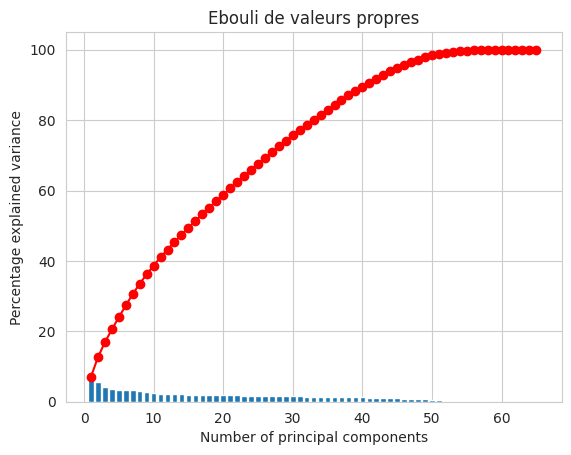

In [60]:
# Scree plot
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Ebouli de valeurs propres")
    plt.show(block=False)
#Utilisation de la fonction pour tracer le scree plot
display_scree_plot(model_pca)

In [61]:
#Nombre de composantes qui concentrent près de 70% de la variance
np.argmax(np.cumsum(model_pca.explained_variance_ratio_*100)>= 70)

26

In [62]:
# Le nombre de composantes à étudier est donc de 2
num_components = 28

In [63]:
#Intéressons nous maintenant à nos fameuses composantes. Nous avons dit dans le cours que c'est bien par un calcul que l'on obtient ces composantes.
#La formule de ce calcul nous est donnée par l'attribut components_. Cette variable est généralement nommée pcs :
pcs = model_pca.components_

In [64]:
#Affichons la même chose mais version pandas principal components :
pcs = pd.DataFrame(pcs)
pcs
#On arrondit pour plus de clarté et in rajoute le nom des colonnes
nomdescolonnes=columns.columns
pcs.columns = nomdescolonnes
pcs.round(2)

,index,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON
0,-0.02,-0.02,-0.20,-0.13,-0.08,-0.11,-0.05,-0.35,0.42,-0.18,...,-0.01,0.02,0.01,-0.02,0.02,0.03,-0.02,-0.42,-0.02,-0.02
1,0.04,0.04,-0.17,0.38,0.34,0.34,0.25,-0.12,0.05,-0.06,...,0.02,0.01,0.01,0.08,0.01,0.01,-0.08,-0.05,-0.02,0.39
2,-0.07,-0.07,-0.25,0.00,-0.29,-0.27,0.01,-0.00,0.08,-0.05,...,-0.00,0.00,-0.01,-0.03,-0.01,-0.01,0.03,-0.08,0.30,0.16
3,0.54,0.54,-0.06,-0.03,-0.02,-0.02,0.05,-0.04,0.01,-0.04,...,-0.03,-0.01,-0.04,0.01,0.02,0.02,0.01,-0.00,0.00,0.01
4,-0.34,-0.34,-0.21,0.11,0.13,0.15,-0.14,0.01,-0.08,0.01,...,0.02,-0.00,-0.02,0.00,0.03,0.09,0.10,0.07,-0.06,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,...,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00
61,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00
62,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,...,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00
63,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00


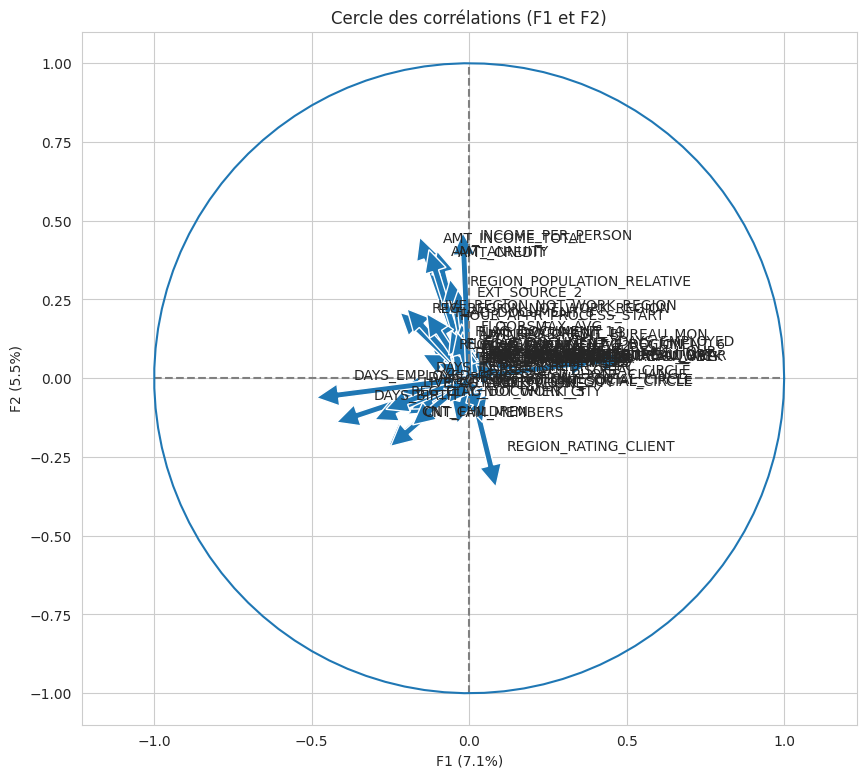

In [65]:
#Définissons nos axes x et y. Nous allons utiliser les 2 premières composantes. Comme - en code - on commence à compter à partir de 0, cela nous donne :
x, y = 0,1
#Pour la partie graphique :

fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, model_pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             model_pca.components_[0, i],  #0 for PC1
             model_pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07,
             width=0.02,              )

    plt.text(model_pca.components_[0, i] + 0.05,
             model_pca.components_[1, i] + 0.05,
             nomdescolonnes[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*model_pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*model_pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
# Ajouter un unit circle for scale
plt.axis('equal')
plt.show(block=False)

In [66]:
import pandas as pd

# Supposons que votre DataFrame est appelé 'resultats'
# Assurez-vous de remplacer 'resultats' par le nom réel de votre DataFrame
data.to_csv('merge.csv', index=False)

# Téléchargez le fichier CSV sur votre machine locale
from google.colab import files
files.download('merge.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
from shutil import move

# Déplacez le fichier CSV dans votre Google Drive
move('merge.csv', '/content/drive/MyDrive/openclass/merge.csv')


'/content/drive/MyDrive/openclass/merge.csv'